## Model Training

### Imports

In [4]:
import torch
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
import os
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace
%matplotlib inline                               
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Get and load data

In [5]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
train_data = datasets.ImageFolder('../data/train/train/', transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=96, shuffle=True)

valid_data = datasets.ImageFolder('../data/valid/valid/', transform=transform)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=96, shuffle=True)

test_data = datasets.ImageFolder('../data/test/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=96, shuffle=True)
# specify the image classes
classes = ['Melanoma','Nevi','Seborrheic Keratoses']

### Visualize some images

In [6]:
# # helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

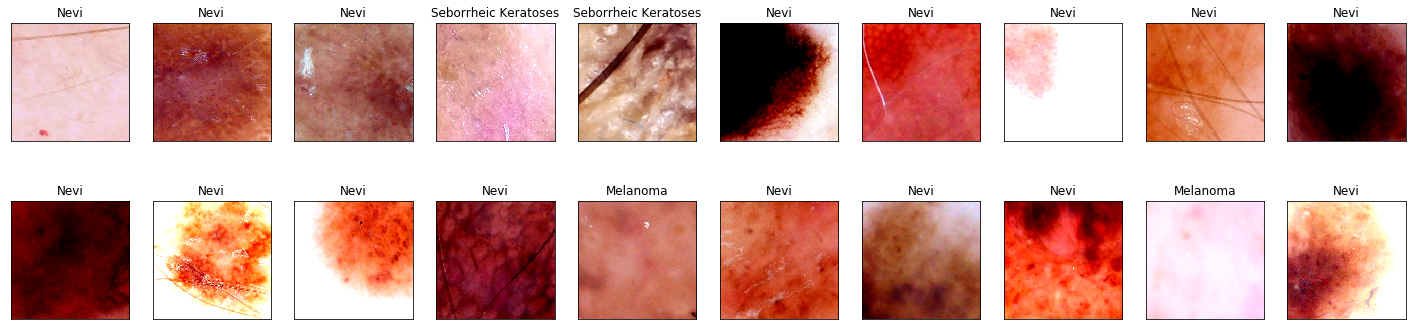

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() 
fig = plt.figure(figsize=(25, 6))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Training Loop

In [7]:
# # the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # track change in validation loss
    train_loss = 0.0
    valid_loss = 0.0
    for epoch in range(1, n_epochs+1):

        # keep track of training and validation loss
        
        ###################
        # train the model #
        ###################
        model.train()
        for images, labels in train_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*images.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for images, labels in valid_loader:
            # move tensors to GPU if CUDA is available
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(images)
            # calculate the batch loss
            loss = criterion(output, labels)
            # update average validation loss 
            valid_loss += loss.item()*images.size(0)

        # calculate average losse
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)

        # print training/validation statistics 
        print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
        # save model if validation loss has decreased
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print(f'validation loss decreased from: {valid_loss_min} ----> {valid_loss}.......Saving Model....')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model

### Test model accuracy

In [27]:
def test(test_loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

### Define transfer learning model

In [9]:
model = models.densenet161(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False
    
model.classifier = nn.Linear(2208, len(train_data.classes))

if use_cuda:
    model_transfer = model.cuda()
model.classifier

Linear(in_features=2208, out_features=3, bias=True)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfer.classifier.parameters(), lr=0.001)

In [ ]:
# train the model
model = train(10, train_loader,valid_loader, model, optimizer, criterion, use_cuda, 'model_transfer.pt')

In [ ]:
test(test_loader, model, criterion, use_cuda)

### Visualize test samples

In [25]:
def visualize(model):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if use_cuda:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        imshow(images.cpu()[idx])
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                     color=("green" if preds[idx]==labels[idx].item() else "red"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

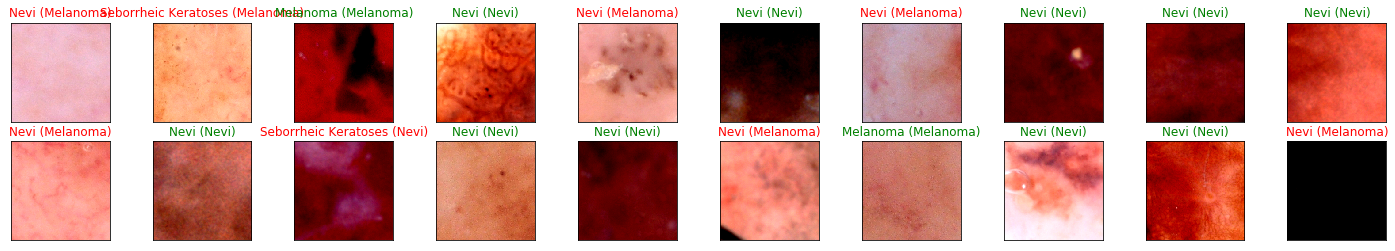

In [26]:
visualize(model)

## Model conversion

In [15]:
model.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>